In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [37]:
import xgboost as xgb

In [38]:
df  = pd.read_csv("DR18_dataset_and_PRF/DR18_SDSS_query_data.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)


In [39]:
df.head()

,objid,ra,dec,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z,specobjid,class,redshift,zErr,plate,mjd,fiberid
0,1237648721770709106,187.031235,0.312479,19.54587,18.20762,17.47258,17.05713,16.79646,0.044090,0.008275,0.006763,0.006663,0.017675,325518697126979584,GALAXY,0.119489,0.000012,289,51990,486
1,1237648721771429938,188.687521,0.366604,17.89789,16.95983,16.53082,16.31973,16.13563,0.013837,0.004129,0.003950,0.004227,0.010427,326628928171042816,GALAXY,0.022601,0.000006,290,51941,429
2,1237648721246290103,215.521934,-0.122110,19.47581,17.98423,17.34529,17.00819,16.75218,0.047616,0.007394,0.006381,0.007011,0.020312,342299712075884544,GALAXY,0.054417,0.000019,304,51609,95
3,1237650796754567296,140.811667,0.430776,19.59742,18.22109,17.59792,17.22872,16.99676,0.036427,0.007086,0.006008,0.006295,0.013851,533786815438546944,GALAXY,0.056572,0.000008,474,52000,401
4,1237650796755550336,143.070673,0.544181,18.22961,17.18746,16.73285,16.36888,16.16996,0.022368,0.008362,0.005037,0.005428,0.013148,536021852967954432,GALAXY,0.107618,0.000008,476,52314,340


In [40]:
#Removing rows with redshift error greater (lesser) than 1 (-1) and greater than the redshift itself
df = df.drop(df[(df['zErr'] > 1) |  (df['zErr'] < -1) & (df['zErr'] >df['redshift'])].index)
print(df.shape[0])

99917


In [41]:
#Numericall represent the class since it is in string format
LE = LabelEncoder()
df['class'] = LE.fit_transform(df['class'])
df['class'].value_counts()

class
0    52322
2    37209
1    10386
Name: count, dtype: int64

In [42]:
X = df[['u','g']]#,'r', 'i', 'z','redshift'
y = df['class']

In [43]:
X

,u,g
0,19.54587,18.20762
1,17.89789,16.95983
2,19.47581,17.98423
3,19.59742,18.22109
4,18.22961,17.18746
...,...,...
99995,17.94874,17.04882
99996,19.23447,17.64933
99997,19.38132,18.94883
99998,17.33268,15.90426


In [44]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    2
99996    0
99997    2
99998    2
99999    2
Name: class, Length: 99917, dtype: int64

In [45]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
class_weights, class_weight_dict

(array([0.63655186, 3.20678477, 0.89509706]),
 {0: 0.6365518647350381, 1: 3.206784774375762, 2: 0.8950970643303143})

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [47]:
X_train

,u,g
11747,19.45431,18.16713
83867,18.90057,17.77251
35159,19.40337,19.32344
49453,18.40589,16.37463
91735,19.36940,18.43569
...,...,...
40100,16.86127,15.24999
2561,19.40141,17.64815
18481,19.56174,17.53241
70355,19.35204,17.48185


In [48]:
xgb_model = xgb.XGBClassifier(num_class=3,sample_weight=class_weights)

In [49]:
xgb_model.fit(X_train,y_train)

/home/sai/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:18:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [50]:
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % (accuracy*100),'%')

Accuracy: 72.95 %


In [51]:
print(classification_report(y_test, y_pred,target_names=LE.inverse_transform(y_test.unique())))

              precision    recall  f1-score   support

         QSO       0.74      0.81      0.77     15697
        STAR       0.81      0.90      0.85      3116
      GALAXY       0.69      0.56      0.62     11163

    accuracy                           0.73     29976
   macro avg       0.74      0.76      0.75     29976
weighted avg       0.73      0.73      0.72     29976



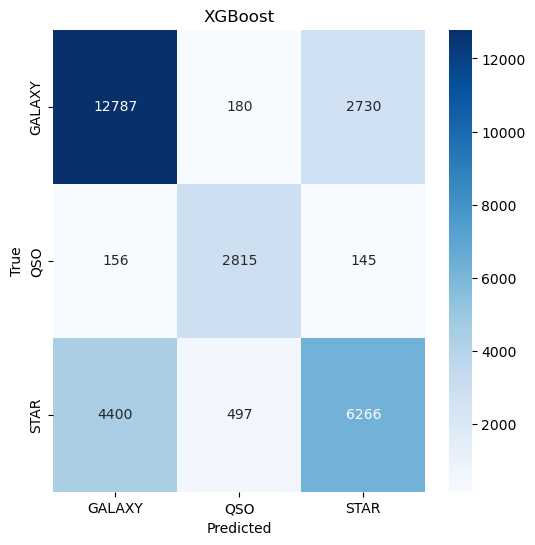

In [52]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'g', cmap = 'Blues', xticklabels = sorted(LE.inverse_transform(y_test.unique())), yticklabels = sorted(LE.inverse_transform(y_test.unique())))
plt.title("XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [53]:
"""

Without redshift, the accuracy drops from 99% to 95%.

With only u and g, the accuracy drops to 73%

"""

SyntaxError: incomplete input (1536071448.py, line 1)